In [2]:
run '~/eddata/eddata/dconn.py'

In [3]:
import pandas as pd
import seaborn as sns
#from dconn import Conn
%matplotlib inline

In [4]:
conn = Conn('eddata', 'dw')

/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
q = """
SELECT
        sft.school_id
        ,sft.county
        ,edm.school_year
        ,sft.school_name
        ,sft.state
        ,sft.is_charter
        ,demographic_group
        ,demographic_value
        ,student_count
FROM
        staging.school_ft sft
    JOIN
        staging.enrollment_dm edm
            ON edm.school_id = sft.school_id
    JOin
LIMIT 10
"""
df = conn.execute_raw_query(q, fmt='df')

In [25]:
q = """
SELECT
        sft.*
        ,edm.school_year
        ,edm.student_count
        ,ddm.*
FROM
        staging.school_ft sft
JOIN
		staging.enrollment_dm edm
	ON edm.school_id = sft.school_id
JOIN
		staging.demographic_dm ddm
    ON ddm.demographic_id = edm.demographic_id::INT
ORDER BY
		sft.school_id
		,edm.school_year;
"""
df = conn.execute_raw_query(q)

In [26]:
df.head().T

,0,1,2,3,4
school_id,1356127,1356127,1356127,1356127,1356127
nces_school_id,010000501616,010000501616,010000501616,010000501616,010000501616
local_school_id,35,35,35,35,35
local_agency_id,101,101,101,101,101
school_name,BIG SPRING LAKE KINDERG SCH,BIG SPRING LAKE KINDERG SCH,BIG SPRING LAKE KINDERG SCH,BIG SPRING LAKE KINDERG SCH,BIG SPRING LAKE KINDERG SCH
phone_number,2568787922,2568787922,2568787922,2568787922,2568787922
location_address,257 COUNTRY CLUB RD,257 COUNTRY CLUB RD,257 COUNTRY CLUB RD,257 COUNTRY CLUB RD,257 COUNTRY CLUB RD
location_city,ALBERTVILLE,ALBERTVILLE,ALBERTVILLE,ALBERTVILLE,ALBERTVILLE
location_state,AL,AL,AL,AL,AL
location_zip,35951,35951,35951,35951,35951


In [27]:
df.groupby(['school_year', 'standardized_demographic_group'])['student_count'].sum()

school_year  standardized_demographic_group
2009-2010    grade                             3713370
             race_x_grade_x_gender             4704896
2010-11      grade                             3772503
             race_x_grade_x_gender             4770522
2011-12      grade                             3856051
             race_x_grade_x_gender             4855026
2012-13      grade                             3859151
             race_x_grade_x_gender             4888032
Name: student_count, dtype: int64

In [22]:
df['standardized_demographic_group'].value_counts()

race_x_grade_x_gender    56298
grade                     2947
Name: standardized_demographic_group, dtype: int64

In [24]:
df[(df['standardized_demographic_group']=='grade')&\
   (df['school_year']=='2012-13')].groupby('standardized_demographic_label')['student_count'].sum()

standardized_demographic_label
kg    59603
Name: student_count, dtype: int64

In [6]:
#calculate the pctile rank of each county wrt count of students
df = df.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')]
        .groupby(['school_year', 'state', 'county'])['student_count'].sum()\
        .groupby('school_year').rank(pct=True).rename('county_size_pctile').reset_index()
    ,on=['school_year', 'state', 'county']
    ,how='left'
)

In [7]:
def f(row):
    share_of_county = row['student_count']/row['county_total']
    row['share_of_county'] = share_of_county
    return row[['school_id','county', 'state', 'share_of_county']]

In [225]:
# ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
# df[(df.demographic_group=='all')&\
#        (df.demographic_value=='all')&\
#        (df.school_year=='2016-17')]\
#     [['state', 'county', 'school_id',  'student_count', 'county_size_pctile']]
#                 )

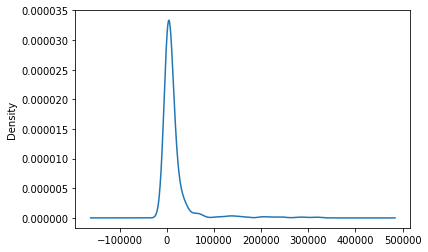

In [8]:
df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')]\
        .groupby(['school_year', 'state', 'county'])['student_count'].sum().plot(kind='density')

(0, 8837.8)

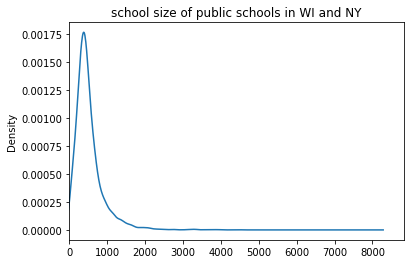

In [250]:
ax = df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&
  (df.school_year=='2015-16')]\
        .groupby(['school_id'])['student_count'].sum().plot(kind='density')

# df[(df.demographic_group=='all')&\
#    (df.demographic_value=='all')&
#    (df.school_year=='2015-16')]\
#         .groupby(['school_id'])['student_count'].sum().apply(lambda x: np.log(x)).plot(kind='density')

ax.set_title('school size of public schools in WI and NY')
ax.set_xlim(0)

(0, 13.786972023246694)

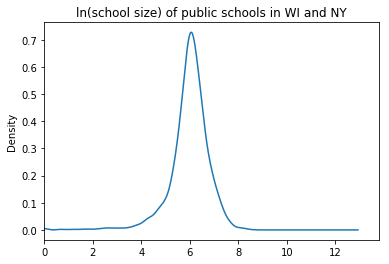

In [251]:
ax = df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&
   (df.school_year=='2015-16')]\
        .groupby(['school_id'])['student_count'].sum().apply(lambda x: np.log(x)).plot(kind='density')

ax.set_title('ln(school size) of public schools in WI and NY')
ax.set_xlim(0)

Text(0.5,1,'Schools are smaller in more populous counties')

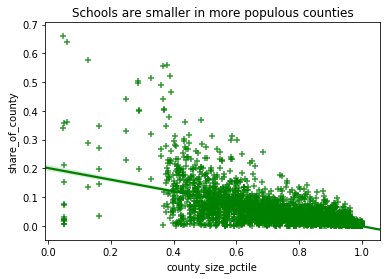

In [20]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
    [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1).where(lambda x: x['share_of_county']<1.0).dropna()\
.merge(
    df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="g",  marker="+")
ax.set_title('Schools are smaller in more populous counties')

In [ ]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
       
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
    [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1).where(lambda x: x['share_of_county']<1.0).dropna()\
.merge(
    df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="g",  marker="+")
ax.set_title('Schools are smaller in more populous counties')

Text(0.5,1,'Schools are smaller in more populous counties')

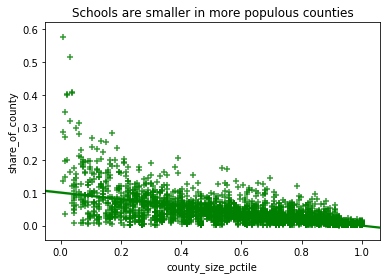

In [57]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
    [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="g",  marker="+")
ax.set_title('Schools are smaller in more populous counties')

In [17]:
df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&\
   (df.state=='LA')&
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)
#['share_of_county'].plot(kind='density')

,school_id,county,state,share_of_county
0,9018,Acadia Parish,LA,0.037538
1,9019,Acadia Parish,LA,0.028625
2,9020,Acadia Parish,LA,0.014155
3,9021,Acadia Parish,LA,0.061864
4,9022,Acadia Parish,LA,0.054105
5,9023,Acadia Parish,LA,0.027367
6,9024,Acadia Parish,LA,0.068680
7,9025,Acadia Parish,LA,0.051379
8,9026,Acadia Parish,LA,0.020761
9,9027,Acadia Parish,LA,0.033239


In [18]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='District Schools')

sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.is_charter==True)&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="r",  marker="+", ax=ax, label='Charters')

ax.set_title('Charters are mad small')
ax.legend()

AttributeError: 'DataFrame' object has no attribute 'share_of_county'

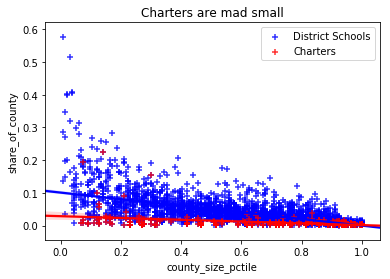

In [65]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='District Schools')

sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.is_charter==True)&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="r",  marker="+", ax=ax, label='Charters')

ax.set_title('Charters are mad small')
ax.legend()

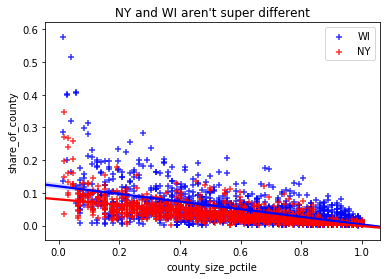

In [72]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&\
   (df.state=='WI')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='WI')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='WI')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='WI')

sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.state=='NY')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='NY')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='NY')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="r",  marker="+", ax=ax, label='NY')

ax.set_title('NY and WI aren\'t super different')
ax.legend()

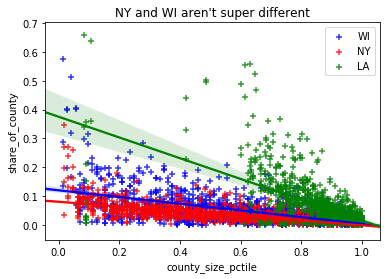

In [25]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.demographic_value=='all')&\
   (df.state=='WI')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='WI')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='WI')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='WI')

sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.state=='NY')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='NY')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='NY')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="r",  marker="+", ax=ax, label='NY')

sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='all')&\
   (df.state=='LA')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='LA')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1).where(lambda x: x['share_of_county']<1.0).dropna()\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='LA')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="g",  marker="+", ax=ax, label='LA')

ax.set_title('NY and WI aren\'t super different')
ax.legend()

In [24]:
df[(df.demographic_group=='all')&\
   (df.state=='LA')&\
   (df.demographic_value=='all')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='LA')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1).where(lambda x: x['share_of_county']<1.0).dropna()\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='LA')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
)

,school_id,county,state,share_of_county,county_size_pctile
0,9018.0,Acadia Parish,LA,0.037538,0.906077
1,9019.0,Acadia Parish,LA,0.028625,0.906077
2,9020.0,Acadia Parish,LA,0.014155,0.906077
3,9021.0,Acadia Parish,LA,0.061864,0.906077
4,9022.0,Acadia Parish,LA,0.054105,0.906077
5,9023.0,Acadia Parish,LA,0.027367,0.906077
6,9024.0,Acadia Parish,LA,0.068680,0.906077
7,9025.0,Acadia Parish,LA,0.051379,0.906077
8,9026.0,Acadia Parish,LA,0.020761,0.906077
9,9027.0,Acadia Parish,LA,0.033239,0.906077


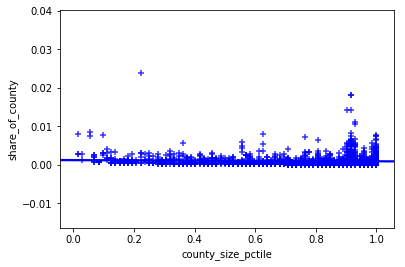

In [74]:
ax = sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='race')&\
   (df.demographic_value=='black')&\
   (df.state=='WI')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='WI')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='WI')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='WI')

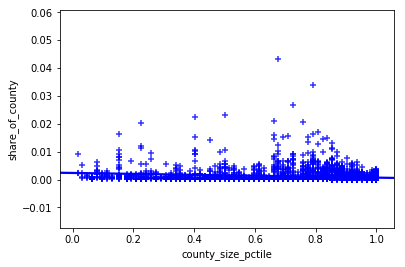

In [75]:
sns.regplot(x="county_size_pctile", y="share_of_county", data=\
df[(df.demographic_group=='race')&\
   (df.demographic_value=='black')&\
   (df.state=='NY')&\
   (df.school_year=='2016-17')]\
        [['state', 'county', 'school_id',  'student_count']]\
.merge(df[(df.demographic_group=='all')&\
          (df.demographic_value=='all')&\
          (df.state=='NY')&\
          (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_total').reset_index()\
    ,on=['state', 'county']
    ,how='left'
).apply(f, axis=1)\
.merge(
    df[(df.demographic_group=='all')&\
       (df.demographic_value=='all')&\
       (df.state=='NY')&\
       (df.school_year=='2016-17')]\
        .groupby(['state', 'county'])['student_count'].sum().rename('county_size_pctile').rank(pct=True).reset_index()\
    ,on=['state', 'county']
    ,how='left'
), color="b",  marker="+", label='WI')

In [77]:
df.head().T

,0,1,2,3,4
school_id,1,1,2,2,3
county,ALBANY,ALBANY,ALBANY,ALBANY,ALBANY
school_year,2011-12,2011-12,2011-12,2011-12,2011-12
school_name,MONTESSORI MAGNET SCHOOL,MONTESSORI MAGNET SCHOOL,PINE HILLS ELEMENTARY SCHOOL,PINE HILLS ELEMENTARY SCHOOL,DELAWARE COMMUNITY SCHOOL
state,NY,NY,NY,NY,NY
is_charter,False,False,False,False,False
demographic_group,disability_status,disability_status,disability_status,disability_status,disability_status
demographic_value,SwoD,SwD,SwoD,SwD,SwoD
student_count,301,27,295,46,376


/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



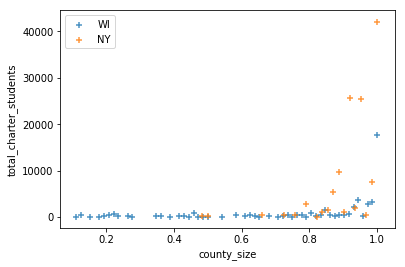

In [109]:
ax = sns.regplot(x='county_size', y='total_charter_students', data=\
    pd.concat([
        df[(df.is_charter==True)&\
           (df.demographic_group=='all')&\
           (df.school_year=='2016-17')&\
            (df.state=='WI')].groupby(['county'])['student_count'].sum()
        .fillna(0).rename('total_charter_students')
        ,df[(df.state=='WI')&\
            (df.school_year=='2016-17')&\
            (df.demographic_group=='all')].groupby(['county'])['student_count'].sum().rank(pct=True).rename('county_size')
    ], axis=1)
    ,label='WI', fit_reg=False,  marker="+")
sns.regplot(x='county_size', y='total_charter_students', data=\

pd.concat([
    df[(df.is_charter==True)&\
       (df.state=='NY')&\
       (df.school_year=='2016-17')&\
       (df.demographic_group=='all')].groupby(['county'])['student_count'].sum()\
         .fillna(0).rename('total_charter_students')
    ,df[(df.state=='NY')&(df.demographic_group=='all')&(df.school_year=='2016-17')].groupby(['county'])['student_count'].sum().rank(pct=True).rename('county_size')
], axis=1)
,label='NY', fit_reg=False,  marker="+")
ax.legend()

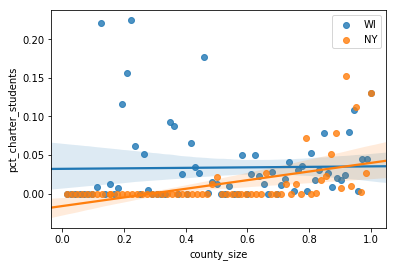

In [180]:
ax = sns.regplot(x='county_size', y='pct_charter_students', data=\
    pd.concat([
        (df[(df.is_charter==True)&\
            (df.demographic_group=='all')&\
            (df.school_year=='2016-17')&\
            (df.state=='WI')].groupby(['county'])['student_count'].sum()/\
        df[(df.demographic_group=='all')&\
           (df.school_year=='2016-17')&\
            (df.state=='WI')].groupby(['county'])['student_count'].sum())\
        .fillna(0).rename('pct_charter_students')
        ,df[(df.demographic_group=='all')&\
            (df.school_year=='2016-17')&\
            (df.state=='WI')].groupby(['county'])['student_count'].sum().rank(pct=True).rename('county_size')
    ], axis=1)
    ,label='WI')
sns.regplot(x='county_size', y='pct_charter_students', data=\

pd.concat([
    (df[(df.is_charter==True)&\
        (df.demographic_group=='all')&\
        (df.school_year=='2016-17')&\
        (df.state=='NY')].groupby(['county'])['student_count'].sum()/\
        df[(df.demographic_group=='all')&\
           (df.school_year=='2016-17')&\
           (df.state=='NY')].groupby(['county'])['student_count'].sum()).fillna(0).rename('pct_charter_students')
    ,df[(df.demographic_group=='all')&\
           (df.school_year=='2016-17')&\
            (df.state=='NY')].groupby(['county'])['student_count'].sum().rank(pct=True).rename('county_size')
], axis=1)
,label='NY')
ax.legend()

In [184]:
cs = ax.collections[0]
cs.set_offset_position('data')
cs.get_offsets()

array([[9.72222222e-02, 0.00000000e+00],
       [2.36111111e-01, 6.12735282e-02],
       [6.25000000e-01, 5.03355705e-02],
       [6.94444444e-02, 0.00000000e+00],
       [9.58333333e-01, 2.88191136e-03],
       [1.66666667e-01, 0.00000000e+00],
       [2.22222222e-01, 2.24456959e-01],
       [4.02777778e-01, 0.00000000e+00],
       [6.94444444e-01, 0.00000000e+00],
       [4.72222222e-01, 6.28798994e-04],
       [6.38888889e-01, 2.32306211e-02],
       [1.80555556e-01, 7.43840074e-03],
       [9.86111111e-01, 4.44123171e-02],
       [6.66666667e-01, 0.00000000e+00],
       [3.33333333e-01, 0.00000000e+00],
       [5.55555556e-01, 0.00000000e+00],
       [5.27777778e-01, 0.00000000e+00],
       [7.77777778e-01, 3.60353611e-02],
       [1.38888889e-02, 0.00000000e+00],
       [8.05555556e-01, 5.32657812e-02],
       [8.33333333e-02, 0.00000000e+00],
       [5.69444444e-01, 0.00000000e+00],
       [4.86111111e-01, 1.46567718e-02],
       [3.05555556e-01, 0.00000000e+00],
       [3.611111

(0, 1.4664307398927003)

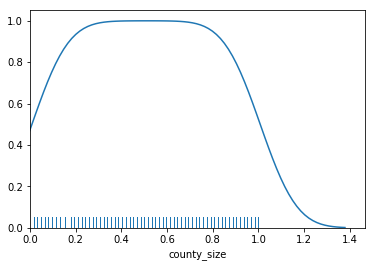

In [179]:
ax = sns.distplot(df[(df.demographic_group=='all')&\
   (df.school_year=='2016-17')&\
   (df.state=='NY')].groupby(['county'])\
['student_count'].sum().rank(pct=True).rename('county_size')
    ,rug=True, hist=False
            )
ax.set_xlim(0)

# for x_lab, x_val in df[(df.demographic_group=='all')&\
#                        (df.school_year=='2016-17')].groupby(['county'])\
#                     ['student_count'].sum().rank(pct=True).rename('county_size').to_dict().items():
#     text_height = random.random()/100000
#     ax.annotate(x_lab, xy=(x_val, text_height))
#     ax.axvline(x_val, ymax=text_height, linestyle='--', lw=2)

In [175]:
df[(df.demographic_group=='all')&\
                       (df.school_year=='2016-17')].groupby(['county'])\
                    ['student_count'].sum().rename('county_size')

county
ALBANY          39292.0
ALLEGANY         6489.0
Adams            1556.0
Ashland          2497.0
BRONX          227092.0
BROOME          25217.0
Barron           7450.0
Bayfield         1486.0
Brown           43027.0
Buffalo          1921.0
Burnett          2486.0
CATTARAUGUS     12088.0
CAYUGA           9294.0
CHAUTAUQUA      19029.0
CHEMUNG         11814.0
CHENANGO         7268.0
CLINTON         10819.0
COLUMBIA         6690.0
CORTLAND         6099.0
Calumet          3848.0
Chippewa         8905.0
Clark            4771.0
Columbia         8308.0
Crawford         2151.0
DELAWARE         6045.0
DUTCHESS        39457.0
Dane            74011.0
Dodge            8493.0
Door             3272.0
Douglas          6165.0
                 ...   
SENECA           4001.0
STEUBEN         14394.0
SUFFOLK        239333.0
SULLIVAN         9210.0
Saint Croix     14220.0
Sauk            11426.0
Sawyer           2215.0
Shawano          5406.0
Sheboygan       18588.0
TIOGA            7695.0
TOMPKINS 

In [176]:
df[(df.demographic_group=='all')&\
                       (df.school_year=='2016-17')].groupby(['county'])\
                    ['student_count'].sum().rename('county_size').sort_values(ascending=False)

county
KINGS          322763.0
QUEENS         288480.0
SUFFOLK        239333.0
BRONX          227092.0
NASSAU         202769.0
NEW YORK       169511.0
WESTCHESTER    149072.0
Milwaukee      135541.0
ERIE           124393.0
MONROE         107176.0
Dane            74011.0
ONONDAGA        70334.0
RICHMOND        62960.0
Waukesha        61281.0
ORANGE          58820.0
Brown           43027.0
DUTCHESS        39457.0
ALBANY          39292.0
ROCKLAND        39237.0
Outagamie       34023.0
ONEIDA          34005.0
SARATOGA        32562.0
Kenosha         28539.0
NIAGARA         28480.0
Racine          28031.0
Rock            27279.0
BROOME          25217.0
ULSTER          21995.0
Winnebago       21968.0
SCHENECTADY     21535.0
                 ...   
Kewaunee         3590.0
Iowa             3488.0
Taylor           3344.0
Door             3272.0
Jackson          3099.0
Green Lake       3067.0
Lafayette        2924.0
Langlade         2849.0
Vilas            2653.0
Waushara         2577.0
Ashland  

In [171]:
x_val

2468.0

In [149]:
ax.locator_params?

In [147]:
import numpy as np

#def test(x, y):
x = data_x
y = data_y

#print(np.interp(1.3, x, y))
Y = 30
eps = 1e-6
j = 0
for i, ((x0, x1), (y0, y1)) in enumerate(zip(zip(x[:-1], x[1:]), zip(y[:-1], y[1:]))):
    dy = y1 - y0
    if abs(dy) < eps:
        if y0 == Y:
            print('There are infinite number of solutions')
    else:
        t = (Y - y0)/dy
        if 0 < t < 1:
            sol = x0 + (x1 - x0)*t
            print('solution #{}: {}'.format(j, sol))
            j += 1
    

98

In [134]:
df[(df.demographic_group=='all')&\
   (df.school_year=='2016-17')&\
   (df.state=='NY')].groupby(['county'])\
['student_count'].sum()

county
ALBANY             39292.0
ALLEGANY            6489.0
BRONX             227092.0
BROOME             25217.0
CATTARAUGUS        12088.0
CAYUGA              9294.0
CHAUTAUQUA         19029.0
CHEMUNG            11814.0
CHENANGO            7268.0
CLINTON            10819.0
COLUMBIA            6690.0
CORTLAND            6099.0
DELAWARE            6045.0
DUTCHESS           39457.0
ERIE              124393.0
ESSEX               3759.0
FRANKLIN            7450.0
FULTON              8187.0
GENESEE             8145.0
GREENE              5833.0
HAMILTON             428.0
HERKIMER            9222.0
JEFFERSON          17596.0
KINGS             322763.0
LEWIS               4298.0
LIVINGSTON          7948.0
MADISON             9278.0
MONROE            107176.0
MONTGOMERY          7057.0
NASSAU            202769.0
                    ...   
ONEIDA             34005.0
ONONDAGA           70334.0
ONTARIO            15553.0
ORANGE             58820.0
ORLEANS             5833.0
OSWEGO             19

In [137]:
#[(x, y) for x, y in dict(zip(data_x, data_y)).items()]

[-0.004523804242941298,
 -0.007085701773138141,
 -0.010782379637086467,
 -0.015934185382540482,
 -0.022857231225644137,
 -0.03180859326061563,
 -0.04291209158200275,
 -0.056070454993865815,
 -0.07087593564609647,
 -0.08653745966158884,
 -0.1018462819879639,
 -0.11520181621840192,
 -0.12471329821166838,
 -0.12838090761175908,
 -0.12434336291826598,
 -0.11116109943859753,
 -0.08808947498887897,
 -0.05528967261784684,
 -0.013929374979619286,
 0.033858483604350474,
 0.08516514376271027,
 0.13662074007808397,
 0.18478558431046974,
 0.2265532698487521,
 0.2594987650736542,
 0.2821169265858977,
 0.29392013081661433,
 0.29539193601917796,
 0.28781992768040315,
 0.2730493815102844,
 0.25320692177401083,
 0.2304399352635419,
 0.2067058001963889,
 0.1836292128001234,
 0.16243036996644034,
 0.14391476896030497,
 0.12850851646762235,
 0.11632123162165413,
 0.10722062536526612,
 0.10090688880896621,
 0.0969795066338924,
 0.09499293167182035,
 0.09450023919682946,
 0.09508544243771447,
 0.09638587040

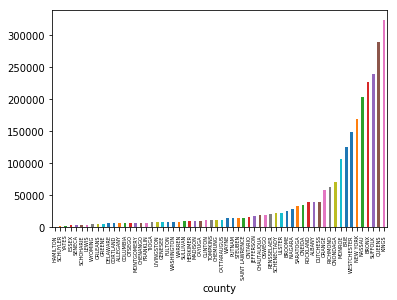

In [126]:
ax = df[(df.demographic_group=='all')&\
   (df.school_year=='2016-17')&\
   (df.state=='NY')].groupby(['county'])\
['student_count'].sum().rename('county_size')\
    .sort_values()\
    .plot(kind='bar')

ax.tick_params(axis='x', labelsize=5)

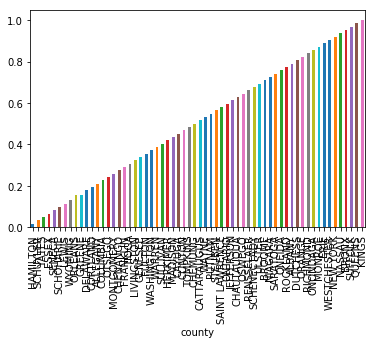

In [124]:
# ax = sns.regplot(
#     x='county', y='county_size', data=\
df[(df.demographic_group=='all')&\
   (df.school_year=='2016-17')&\
   (df.state=='NY')].groupby(['county'])\
['student_count'].sum().rank(pct=True).rename('county_size')\
    .sort_values()\
    .plot(kind='bar')

In [87]:
x = 5
3<x<9

True

In [91]:
pd.concat([
    (df[(df.is_charter==True)&\
        (df.demographic_group=='all')&\
        (df.school_year=='2016-17')&\
        (df.state=='WI')].groupby(['county'])['student_count'].sum()/\
    df[(df.demographic_group=='all')&\
       (df.school_year=='2016-17')&\
        (df.state=='WI')].groupby(['county'])['student_count'].sum())\
    .fillna(0).rename('pct_charter_students')
    ,df[(df.demographic_group=='all')&\
        (df.school_year=='2016-17')&\
        (df.state=='WI')].groupby(['county'])['student_count'].sum().rank(pct=True).rename('county_size')
], axis=1).where(lambda row: (row['pct_charter_students']>0.07)&(row['county_size']<0.5)).dropna().index

Index(['Burnett', 'Iowa', 'Lincoln', 'Marquette', 'Sawyer', 'Taylor',
       'Washburn'],
      dtype='object', name='county')

In [93]:
rural_charters = ['Burnett', 'Iowa', 'Lincoln', 'Marquette', 'Sawyer', 'Taylor',
       'Washburn']

In [95]:
(df[(df.is_charter==True)&\
     (df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters))].groupby('demographic_value')['student_count'].sum())/\
(df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters))].groupby('demographic_value')['student_count'].sum())

demographic_value
asian       0.243478
black       0.358491
hispanic    0.175617
multi       0.128205
native      0.046512
white       0.147950
Name: student_count, dtype: float64

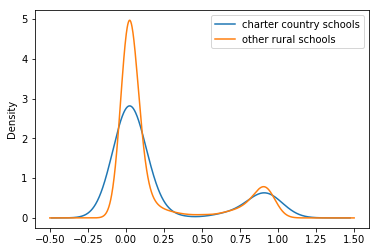

In [107]:
ax = (df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters))].groupby(['demographic_value', 'school_id'])['student_count'].sum()/\
df[(df.school_year=='2016-17')&\
     (df.demographic_group=='all')&\
   (df.county.isin(rural_charters))].groupby(['school_id'])['student_count'].sum()).plot(kind='density', label='charter country schools')


(df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters+['Milwaukee', 'Dane'])==False)&\
   (df.state=='WI')].groupby(['demographic_value', 'school_id'])['student_count'].sum()/\
df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters+['Milwaukee', 'Dane'])==False)&\
   (df.state=='WI')&\
   (df.county!='Milwaukee')].groupby(['school_id'])['student_count'].sum()).plot(ax=ax, kind='density', label='other rural schools')

ax.legend()

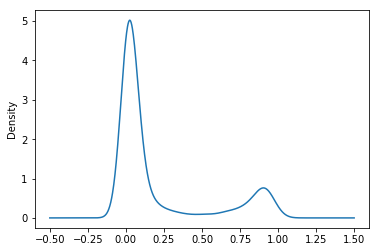

In [103]:
(df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters)==False)&\
   (df.state=='WI')&\
   (df.county!='Milwaukee')].groupby(['demographic_value', 'school_id'])['student_count'].sum()/\
df[(df.school_year=='2016-17')&\
     (df.demographic_group=='race')&\
   (df.county.isin(rural_charters)==False)&\
   (df.state=='WI')&\
   (df.county!='Milwaukee')].groupby(['school_id'])['student_count'].sum()).plot(kind='density')

In [23]:
df[(df.school_year=='2016-17')&
   (df.demographic_group=='all')]\
.groupby(['state', 'is_charter'])['student_count'].mean()

state  is_charter
NY     False         573.622357
       True          505.382470
WI     False         424.533121
       True          168.007937
Name: student_count, dtype: float64